## Dyna planning

#### Background

The aim of this part of the assignment is to introduce you to the concept of Dyna (Sutton, 1990). By now you will have heard about model-free (MF) and model-based (MB) approaches to control. MF algorithms learn and store estimates of the state-action value function. This means that control simply involves retrieving those cached value estimates and choosing among the available actions by comparing their worth. MB control, on the other hand, involves the use of a model to calculate those values. In the RL literature this is typically known as planning. Planning has the advantage of affording behavioural flexibility, since once a change in the world is discovered the model can be updated and the values re-calculated in a way that reflects the global knowledge of the environment. By contrast, MF algorithms need many experiences to propagate the information about the change to other states.

Dyna (Sutton, 1990) is an integrated architecture which combines the merits of MF and MB approaches. Whilst interacting with the environment (i.e., being online), Dyna learns MF state-action values as well as a model of its environment (in the most general sense this involves both the transition and reward models). Whilst not interacting with the environment (i.e., being offline -- this can be in between consecutive moves or episodes, or during the equivalent of sleep in animals), Dyna uses its learnt model to additinally train the MF values. That is, the model now acts as a simulator of the environment and provides additional experiences for learning. This means that at decision time Dyna is fast to react, since it acts according to an MF policy by simply retrieving the relevant values; however, those values have been trained by a model and therefore contain some portion of the global knowledge of the environment collected so far.

One particularly critical aspect of learning is exploration, and in fact Dyna's original motivation was to improve the efficiency of exploration. You are invited to read the original paper by Sutton (1990) to familiarise yourself with the idea and the sort of problems it attempts to solve. The pdf of the paper can be found in the `papers` folder of this repository.

#### Task 1 [10 marks]

The first part of the assignment is to reproduce some of the results from the original Dyna paper (Sutton, 1990). In particular, **your task is to generate and visualise data plotted in figure 6** in that paper. You can neglect Dyna-PI and only implement Dyna-$Q$- and Dyna-$Q$+.

To make your life a little easier, and to let you jump right into the more interesting stuff, you are provided with the environment simulator located in `environment.py`, as well as a blueprint of the main code for the agent. That is, you have access to the file `agent.py` where you will find the `DynaAgent` class. This class has a method called `simulate` with the main simulation loop already implemented.

**Your task is to fill in the missing implementation** in the `agent.py` file. Thus, you are tasked to complete the following functions:
- `_policy`. This is the typical $\pi(a\mid s)$ which specifies how the agent chooses actions in any given state
- `_update_qvals`. This is the $Q$-value update rule
- `_update_experience_buffer`. This updates the agent's experience buffer from which it then samples planning updates
- `_update_action_count`. This counts the number of moves elapsed since each action has last been attempted
- `_plan`. This is the function which lets the agent plan

Once that's done you can run the code below which will hopefully reproduce the figure

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from write_load import load_env
from agent import DynaAgent

In [2]:
# load environments
maze_conf_path = os.path.abspath(os.path.join(os.getcwd(), '..', 'envs'))
maze1_conf = load_env(os.path.join(maze_conf_path, 'dyna1.txt')) # maze with only the right path open 
maze2_conf = load_env(os.path.join(maze_conf_path, 'dyna2.txt')) # maze with both paths open

In [3]:
# initialise the agents
# note that alpha is the learning rate (instead of beta as in the paper)
dyna_qplus  = DynaAgent(alpha=0.5, gamma=0.9, epsilon=0.001, eps_2=0.001, bonus = 1)
dyna_qminus = DynaAgent(alpha=0.5, gamma=0.9, epsilon=0, eps_2 = 0.001, bonus = 0)
dyna_entr = DynaAgent(alpha=0.5, gamma=0.9, epsilon=0.001, eps_2 = 0.1, bonus = 2)

In [4]:
np.random.seed(2)
# run simulations
num_trials = 3000
num_runs   = 50
perf       = [np.zeros((num_runs, num_trials*2)), np.zeros((num_runs, num_trials*2)), np.zeros((num_runs, num_trials*2))]
agents     = [dyna_qplus, dyna_qminus, dyna_entr]
#agents     = [dyna_sa]

for idx_agent, agent in enumerate(agents):
    for idx_run in range(num_runs):
        agent.init_env(**maze1_conf)
        agent.simulate(num_trials=num_trials, reset_agent=True, num_planning_updates=10)
        # world change
        agent.init_env(**maze2_conf)
        agent.simulate(num_trials=num_trials, reset_agent=False, num_planning_updates=10)
        # save performance
        perf[idx_agent][idx_run, :] = agent.get_performace()
        if (idx_run+1)%10 == 0:
            print('done with run %u/%u'%(idx_run+1, num_runs))

# average cumulative reward
avg_perf_dyna_qplus  = np.mean(perf[0], axis=0)
avg_perf_dyna_qminus = np.mean(perf[1], axis=0)
avg_perf_dyna_entr = np.mean(perf[2], axis=0)

done with run 10/50
done with run 20/50
done with run 30/50
done with run 40/50
done with run 50/50
done with run 10/50
done with run 20/50
done with run 30/50
done with run 40/50
done with run 50/50
done with run 10/50
done with run 20/50
done with run 30/50
done with run 40/50
done with run 50/50


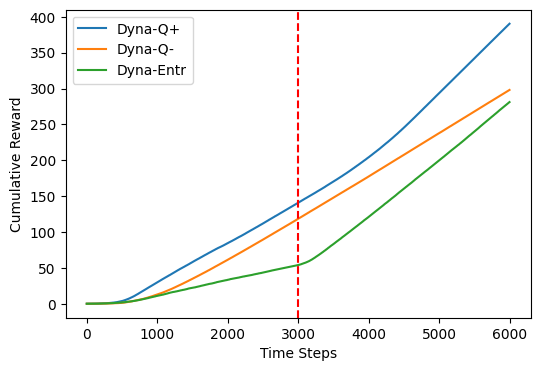

In [6]:
# plot Figure 6 from Sutton (1990) here
plt.figure(figsize=(6, 4))
plt.plot(avg_perf_dyna_qplus,  label='Dyna-Q+')
plt.plot(avg_perf_dyna_qminus, label='Dyna-Q-')
plt.plot(avg_perf_dyna_entr,  label='Dyna-Entr')
plt.axvline(3000, linestyle='--', c='r')
plt.xlabel("Time Steps")
plt.ylabel("Cumulative Reward")
plt.legend()

Describe in your own words the apparent differences you observe in the above plot. Some of those differences involve the particular choice of the exploration bonus used in this algorithm. Suggest and implement another sensible exploration bonus and compare the performance of your agent against Dyna-$Q$+ and Dyna-$Q$-. Explain your choice. 

As it can be seen in the plot, after 4000 trials, the slope of Dyna-Q+ is steeper than the one for Dyna-Q-, which stays the same over time. Related to the task, it implies that Dyna-Q+learns and takes the shortcut for maze 2, while Dyna-Q- on the other hand does not. The reason for that is the exploration bonus that was implemented for Dyna-Q+, which let the model explore more even when the optimal path for the first environment was found, thanks to the exploration bonus it kept looking for other ways and was eventually able to find the shortcut. The exploration bonus is a great way of encouraging more exploration, mainly because the environments can change over time. 

For the second exploration bonus, I choose to use entropy based exploration bonus, which is based on the uncertainty with the distribution os action probabilities, it encourages the exploration of the actions that have higher uncertainty. First the softmax action is used to calculate the probabilities and the formula for the entropy is later implemented. At the beginning, the results against the Dyna-Q+ are much worse, but over time, we can see it reaches the same slope, which suggests that is able to explore and learn the shortcut. 

## 2-step task

#### Background

The 2-step task is one of the most iconic RL tasks (Daw et al. 2011). It was designed to dissect the relative contributions of the MF and MB systems in human choices. There are multiple ways in which MB information can enter choice. For instance, as you will have seen in the case of Dyna, the MF values are additionally trained by the MB system during offline behavioural states. In fact, this process of Dyna-style planning parallels closely hippocampal replay which has been suggested to implement MB planning (Mattar \& Daw, 2018).

For the purpose of this exercise, we will assume that the choice is guided by a linear combination of the MF and MB values. Thus, by tweaking the relative contribution of each, you would expect different behaviours to emerge. Classically, the measure of this balance used in the 2-step task is stay probability. That is, the probability that the subject/agent repeats the same first-stage choice conditioned on the outcome of the second stage in the previous trial.

#### Task 2 [20 marks]

For this part of the assigniment, **your task is to reproduce and visualise data plotted in figure 2** in Daw et al. (2011). There is no pre-implemented code for the agent, except for some basics in the `agent.py` file where you can find the `TwoStepAgent` class. Therefore, you have to follow the methodology in the paper and implement it yourself. You can find the relevant paper in the `papers` folder of this git repository. The only provided code is the one below, as well as the `get_stay_probabilities` method.

In [6]:
import os
import numpy as np
import matplotlib.pyplot as plt
from write_load import load_env
from agent import TwoStepAgent

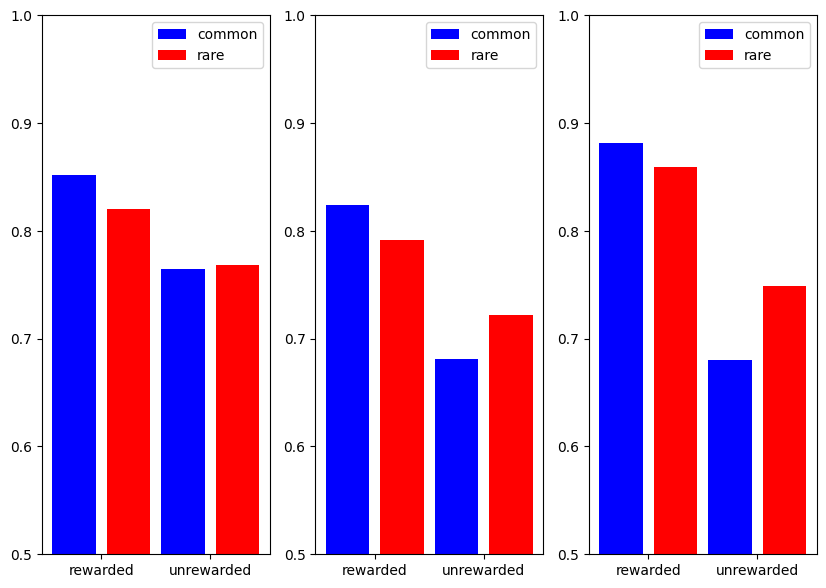

In [7]:
w = [0,0.39, 1]
fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (10, 7))
for ax, w in zip(axes, w):
    agent = TwoStepAgent(alpha1=0.54, alpha2=0.42, beta1=5.19, beta2=3.69, lam=0.57, w=w, p=0.11)
    np.random.seed(2)
    # run simulations
    num_trials  = 201
    num_averg   = 17
    stay_probas = np.zeros((num_averg, 4))
    for n in range(num_averg):
        agent.simulate(num_trials)
        stay_probas[n, :] = agent.get_stay_probabilities()
    ax.bar(1, np.mean(stay_probas[:, 0]), facecolor='blue', label='common')
    ax.bar(2, np.mean(stay_probas[:, 1]), facecolor='red', label='rare')
    ax.bar(3, np.mean(stay_probas[:, 2]), facecolor='blue')
    ax.bar(4, np.mean(stay_probas[:, 3]), facecolor='red')
    ax.set_ylim(0.5, 1)
    ax.set_xticks([1.5, 3.5], ['rewarded', 'unrewarded'])
    ax.legend()

plt.show()

Describe in your own words the apparent differences between the MF and MB agents. What do the data plotted with best-fitting parameters tell you about the relative contributions of MF and MB systems to subjects' choices?

The MF agents bases its predictions on trial-error, so based on real experience, the update of the action values is based on the immediate rewards it received. Unlike MF, MB is able to generate an internal model, which helps it to plan its actions in order to get the optimal outcome. The internal model helps it simulate the possible futurre rrewards and how actions lead to different states to generate rewards. In other words, the first plot from Figure 2 of the paper suggests that if the choice we made in the first choice lead to a reward, with a MF agent, it would more likely to be repeated, no matter if we were on the rare or common stage. The second plot however, shows how a MB agent would investigate the factors of reward and transition probability. Finally C shows that in real life, we do a combination of both. 

If the beta values are high, we cann say that the agents choices rely on the immediate rewards they receive, however if the alphas are high, it can be said that the agent is taking into account the transition probabilities (0.7 and 0.3) in order to make the optimal choice. Also, the parameter we are using w, is between 0 and 1, which is between MF and MB respectively. If the value of w gets closer to 1, it will be more heavily influences by MB and vice versa. 